In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "A_C_OF_alpha.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =["sample_id"] #
output_cols = None
n_comps = [i for i in range(1,101)]
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/1.03") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")
preprocessing = None

Output directory is D:\workspace\lazydeep\experiments\1.03\A_C_OF_alpha


In [3]:
data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = CrossValEvaluation(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (7329, 1703)


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="log",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="test_log",file_name=log_dir/"test_log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")
#step 1, run pls, set up pls - that runs best
n_comps = [i for i in range(1,min(101,n_features))]
pls_models = {i:PLSRegression(n_components=i) for i in n_comps}

pls_scheme = SKLearnScheme(logger="log")
scores_pls, preds_pls, model_states_pls , train_time_pls, test_time_pls,_ = eval.evaluate(pls_models,dataset,pls_scheme,logger_name="log")
summary_logger.info(f"Train times: {train_time_pls}")
summary_logger.info(f"Test times: {test_time_pls}")
from collections import defaultdict
summary_logger.info(f"Scores: {scores_pls}")
last_r2 = -math.inf
selected_comps = -1

for i,(key,value) in enumerate(flip_dicts(scores_pls).items()):
    summary_logger.info(f"{key}: {value}")
    
for i,(key,value) in enumerate(flip_dicts(scores_pls).items()):
    new_r2  = value["R2"]
    if new_r2 - last_r2 <= 0.01:
        selected_comps = i-1
        break
    if i == 99:
        selected_comps =  min(scores_pls["MSE"],key=scores_pls["MSE"].get)
    last_r2 = new_r2

summary_logger.info(f"Selected pls preprocessing with {selected_comps} components")


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training SKLearn with a train loss of 1:146.1348,2:70.8467,3:64.3755,4:48.538,5:42.7448,6:40.3484,7:38.8755,8:34.6236,9:32.0313,10:29.8035,11:28.1088,12:26.9521,13:25.6742,14:23.9445,15:22.8661,16:22.0874,17:21.108,18:20.6937,19:20.2059,20:19.5925,21:19.38,22:18.9099,23:18.6831,24:18.4312,25:18.2609,26:18.0362,27:17.7377,28:17.4944,29:17.3079,30:17.1078,31:16.9749,32:16.8993,33:16.713,34:16.5388,35:16.3781,36:16.2748,37:16.1708,38:16.0346,39:15.9536,40:15.8593,41:15.7793,42:15.6916,43:15.6036,44:15.4942,45:15.4174,46:15.3516,47:15.2865,48:15.2077,49:15.1243,50:15.0268,51:14.9679,52:14.8892,53:14.8377,54:14.7843,55:14.7217,56:14.6857,57:14.6535,58:14.6057,59:14.5669,60:14.5336,61:14.4951,62:14.4484,63:14.4157,64:14.3832,65:14.3438,66:14.3083,67:14.2787,68:14.2399,69:14.2045,70:14.1793,71:14.1477,72:14.1129,73:14.082,74:14.0548,

In [5]:
eval = CrossValEvaluation(preprocessing=PLSRegression(n_components=selected_comps),tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [6]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=selected_comps,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

deep_models = {name:RandomNet(input_size=selected_comps,
                             n_layers=config.n_layers,
                             act_function=config.act_function,
                             n_features = config.n_features,
                             dropout=config.dropout,
                             batch_norm=config.batch_norm,
                             device=device,dtype=torch.float)
              for name, config in configs.items()}

ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(deep_models,configs,log_dir)
start = datetime.datetime.now()



Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'


In [7]:
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores_deep, preds_deep, model_states_deep , train_time_deep, test_time_deep,pp_state = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log")

scores_final, preds_final, model_states_ls_final , train_time_deep_final, test_time_deep_final,pp_state_final = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log")


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Training extractors on 3663 instances, validating on 1222 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.581204),random_2:84.693(-0.901208),random_3:202.364(-0.56051),random_4:nan(-0.510167),random_5:110.3445(-0.980977),random_6:92.6519(-0.924832),random_7:nan(-0.940597),random_8:137.7454(-0.73093),random_9:37091193.6448(-0.907654),random_10:nan(-0.682478),random_11:109.7671(-0.897968),random_12:34408364.2968(-0.082903),random_13:nan(-0.813354),random_14:nan(-0.15142),random_15:427.8296(-0.488761),random_16:235.7389(-0.862446),random_17:nan(-0.447822),random_18:84.9339(-0.259096),random_19:122.8388(-0.033556),random_20:nan(-0.232474),random_21:264.3713(-0.684561),random_22:208.7158(-0.111175),random_23:nan(-0.105224),random_24:190.5817(-0.728931),random_25:192.5061(-0.9206

In [8]:
for model, state_dict in model_states_ls_final.items():
     torch.save(state_dict.state(), log_dir / "models" / f"{model}" / f"_final")
        
if not preprocessing is None:
    ex.save_pp(pp_state,log_dir)
    PLSRegression(n_components=selected_comps).save_state(pp_state_final.state(),log_dir / "preprocessing"   / f"_final")
        
summary_logger.info(f"Train times: {train_time_deep}")
summary_logger.info(f"Test times: {test_time_deep}")
ex.save_results(model_states_deep, preds_deep, configs, scores_deep, log_dir,tb)


end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, deep_models, scores_deep)
ex.save_pred_plots(preds_deep, deep_models, log_dir)



Train times: {'fold_0': 1492, 'fold_1': 1501, 'fold_2': 1489, 'fold_3': 1501, 'fold_4': 1506, 'mean': 1497.8}'
Test times: {'fold_0': 1, 'fold_1': 1, 'fold_2': 1, 'fold_3': 1, 'fold_4': 1, 'mean': 1.0}'
Experiments took 2:37:35.789608'
Finished Random Deep Search'
---Loss results---'
0 - random_6 - fold_0:25.8176,fold_1:20.3675,fold_2:17.7316,fold_3:19.5142,fold_4:38.5346,MSE:24.3927,R2:0.8904'
1 - random_46 - fold_0:23.746,fold_1:21.6109,fold_2:19.8058,fold_3:20.1401,fold_4:37.1367,MSE:24.4873,R2:0.8899'
2 - random_57 - fold_0:24.6537,fold_1:21.1458,fold_2:17.8447,fold_3:20.1577,fold_4:40.4238,MSE:24.8445,R2:0.8883'
3 - random_44 - fold_0:24.8087,fold_1:19.6158,fold_2:18.4405,fold_3:20.3153,fold_4:43.9683,MSE:25.4287,R2:0.8857'
4 - random_40 - fold_0:29.8941,fold_1:23.8665,fold_2:20.6762,fold_3:20.6243,fold_4:36.0486,MSE:26.2221,R2:0.8821'
5 - random_58 - fold_0:27.2117,fold_1:19.6467,fold_2:18.5067,fold_3:19.0575,fold_4:48.4876,MSE:26.581,R2:0.8805'
6 - random_18 - fold_0:33.2048,fol

### Plotting deep results as a function of number of features

In [9]:
scores_df = pd.DataFrame(scores_deep)
scores_df.to_csv(log_dir / f"scores.csv", index=False)


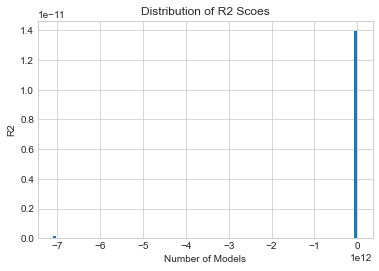

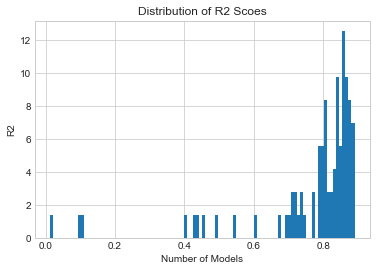

In [10]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [11]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val MSE - Val R2 - Test MSE - Test R2")
for i,key in enumerate(sorted(scores_deep['MSE'],key=scores_deep['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores_deep['MSE'][key]} -{scores_deep['R2'][key]} - {scores_final['MSE'][key]} - {scores_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val MSE - Val R2 - Test MSE - Test R2'
0 - random_6 - 24.39266047221395 -0.8903546237988402 - 21.463867877504608 - 0.9276612899321924'
1 - random_46 - 24.487323697555585 -0.889929111175204 - 28.795938364758413 - 0.902950342017252'
2 - random_57 - 24.8445103415842 -0.8883235518306971 - 25.926782400500176 - 0.9126201295235067'
3 - random_44 - 25.42868469544431 -0.8856976793118293 - 25.4561461072368 - 0.9142062938886651'
4 - random_40 - 26.22214752102794 -0.8821310519604645 - 24.637074649329165 - 0.9169667736426659'
